In [1]:
# !pip install -e ./task_model


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.image import rgb_to_grayscale, image_gradients

from task_model.task_unet_model import MobileNetV2_UNet_Attn as unet_model
from task_model.losses import focal_tversky, dice_coef, tversky

from sklearn.metrics import precision_score, recall_score

import json
from skimage import io, morphology
from pathlib import Path
from datetime import datetime

import shutil

ModuleNotFoundError: No module named 'attention'

In [3]:
# set some base variables up
DEFAULT_IMAGE_SIZE = [512, 512, 3]
DEFAULT_BATCH = 6
DEFAULT_NUM_CHANNELS = 3

# designate model name identifier, if any
DEFAULT_SAVE_MODEL = True
model_savebase = 'unet_attn_TverskyBCE_aug'

# set some path variables up
base_dir = Path('C:/Users/NPDan/Documents/GitHub/task_challenge/data')

# test setup on cpu, Omit for train
# tf.config.set_visible_devices([], 'GPU')

In [4]:
# pull in the dataset dataframes
train_df_path = base_dir / 'train_df_base.json'
with open(train_df_path, 'r') as fp:
    train_df = pd.read_json(fp)
valid_df_path = base_dir / 'valid_df_base.json'
with open(valid_df_path, 'r') as fp:
    valid_df = pd.read_json(fp)
test_df_path = base_dir / 'test_df_base.json'
with open(test_df_path, 'r') as fp:
    test_df = pd.read_json(fp)

Alright, first things first, we need to construct a dataset. That means parsing through each image in the training, test and validation datasets and copying them to a new folder

In [5]:
# define base and set dirs
dataset_dir = base_dir / 'datasets_base'
train_dir, valid_dir, test_dir = dataset_dir / 'train', dataset_dir / 'valid', dataset_dir / 'test'

# define sub-sub dirs
img_sub_dir, msk_sub_dir = 'images', 'masks'

In [6]:
# Sanity check
# valid_df.columns, valid_df.head()

Alright, we have our dataset, let's get our dataloaders set up and get crankin'

In [7]:
# let's reuse our janky image read methods to parse in our x, y paths
def read_data(path, float_convert=True, scale_fctr=255., return_3D=True):
    # type enforcement for consistency
    if not isinstance(path, (Path, str)):
        path = path.decode()
    if float_convert:
        data = _read_float(path, scale_fctr)
    else:
        data = _read_u8(path, scale_fctr)
    if return_3D:
        data = np.atleast_3d(data)
    return data

def _read_float(path, scale_fctr=1.):
    x = io.imread(path) / scale_fctr
    return x.astype('float32') 

def _read_u8(path, scale_fctr=1):
    x = io.imread(path) / scale_fctr
    return x.astype('uint8')

In [ ]:
def make_boundary(y, width=2):
    y_bd = morphology.dilation(np.squeeze(y), morphology.square(width*2+1))
    return np.squeeze(y_bd) - np.squeeze(y)

In [8]:
# let's get our datasets
def tf_parse(x, y, image_size=DEFAULT_IMAGE_SIZE[0], num_classes=DEFAULT_NUM_CHANNELS):
    def _parse(x, y):
        x = read_data(x, True)
        y = read_data(y, True, 255.)
        if num_classes == 3:
            # dilate mask to make boundary, concatenate result
            y_bd = np.atleast_3d(make_boundary(y))
            y = np.concatenate((y, y_bd), axis=2)
        if num_classes > 1:
            # define bg as absence of other classes, concatenate result
            y_bg = np.atleast_3d(np.logical_not(np.any(y > 0, axis=2)))
            y = np.concatenate((y, y_bg), axis=2)
        return x, y
    
    # NOTE: need to be careful, not 100% what these are doing
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([image_size, image_size, 3])
    y.set_shape([image_size, image_size, num_classes])
    return x, y

# let's get our datasets
def tf_parse(x, y, image_size=DEFAULT_IMAGE_SIZE[0], num_classes=DEFAULT_NUM_CHANNELS):
    def _parse(x, y):
        x = read_data(x, True)
        y = read_data(y, True, 255.)
        return x, y
    
    # NOTE: need to be careful, not 100% what these are doing
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([image_size, image_size, 3])
    y.set_shape([image_size, image_size, num_classes])
    return x, y

def tf_dataset(x, y, batch=DEFAULT_BATCH):
    # duplicate sample_weights to match full dataset size... Ugh...
    # define dataset size, map parse function, batch and allow repeat loop    
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
# get our path vectors
train_x = sorted([str(p) for p in Path(train_df[img_sub_dir].unique()[0]).glob('*.png')])
train_y = sorted([str(p) for p in Path(train_df[msk_sub_dir].unique()[0]).glob('*.png')])
valid_x = sorted([str(p) for p in Path(valid_df[img_sub_dir].unique()[0]).glob('*.png')])
valid_y = sorted([str(p) for p in Path(valid_df[msk_sub_dir].unique()[0]).glob('*.png')])
test_x = sorted([str(p) for p in Path(test_df[img_sub_dir].unique()[0]).glob('*.png')])
test_y = sorted([str(p) for p in Path(test_df[msk_sub_dir].unique()[0]).glob('*.png')])

# get our tf datasets
train_dataset = tf_dataset(train_x, train_y, batch=DEFAULT_BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=DEFAULT_BATCH)
test_dataset = tf_dataset(test_x, test_y, batch=DEFAULT_BATCH)

In [10]:
# sanity check, is our data the right shape
train_dataset.element_spec, len(test_x) # Huzzah!


((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)),
 165)

In [11]:
x, y = next(train_dataset.as_numpy_iterator())
x.shape, y.shape

((6, 512, 512, 3), (6, 512, 512, 1))

Moment of truth... let's instantiate our optimizer and callbacks and start fittin'

In [12]:
# wrap tversky call to enable modified alpha value
DEFAULT_ALPHA = 0.6
DEFAULT_GAMMA = 4/3
DEFAULT_F_BETA = 1.3333
DEFAULT_EPS = 1e-6

def focal_tversky_wp(y_true, y_pred, alpha=DEFAULT_ALPHA, gamma=DEFAULT_GAMMA, const=DEFAULT_EPS):
    return focal_tversky(y_true, y_pred, alpha, gamma, const)

def tversky_wp(y_true, y_pred, alpha=DEFAULT_ALPHA, const=DEFAULT_EPS):
    return tversky(y_true, y_pred, alpha, const)

def mean_iou(y_true, y_pred, smooth=DEFAULT_EPS, convert_bool=True):
    def _miou_score(y_true, y_pred, thresh=0.5, smooth=DEFAULT_EPS):
        y_true = y_true.flatten() > thresh
        y_pred = y_pred.flatten() > thresh
        intersection = np.logical_and(y_true, y_pred).sum() + smooth
        union = np.logical_or(y_true, y_pred).sum() + smooth
        return (intersection / union).astype('float32')
    
    return tf.numpy_function(_miou_score, [y_true, y_pred], [tf.float32])

# modified f1 score - optimizes precision and recall
# https://en.wikipedia.org/wiki/F-score - beta = .5 ->  2x weight precision
def f_beta(y_true, y_pred, beta=DEFAULT_F_BETA, smooth=DEFAULT_EPS):
    beta *= beta
    beta_coef = 1 + beta
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return (beta_coef * tp + smooth) / (beta_coef * tp + beta * fn + fp + smooth)

In [13]:
def miou_score(y_true, y_pred, thresh=0.5):
    y_true = y_true.flatten() > thresh
    y_pred = y_pred.flatten() > thresh
    return np.logical_and(y_true, y_pred).sum()/np.logical_or(y_true, y_pred).sum()

In [14]:
def visualize_image_and_mask(x_img, y_true=None, y_pred=None,
                             mask_cmap_name='winter', show_axis=True, title_prefix = ''):
    # plot original
    fig = plt.figure()
    plt.subplot(1,2,1)
    if y_true is not None:
        # overlay mask if applicable
        y_true = y_true.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Truth')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_true, alpha=0.4*y_true, vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Image')))
        plt.imshow(x_img)
    if not show_axis:
        plt.axis('off')
        
    # plot augmented
    if y_pred is not None:
        plt.subplot(1,2,2)
        # overlay mask if applicable
        y_pred = y_pred.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Predicted')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_pred, alpha=0.4*y_pred.squeeze(), vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
        if not show_axis:
            plt.axis('off')
    plt.show()

In [15]:
# set seed for RNG
tf.random.set_seed(3)
model = unet_model(num_channels=DEFAULT_NUM_CHANNELS)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         encoder_input[0][0]              
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [17]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.002),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta = 0.001),
]

# SET training steps - validation data includes auto-augmentations
train_steps = len(train_x)//DEFAULT_BATCH
valid_steps = len(valid_x)//DEFAULT_BATCH
if len(train_x) % DEFAULT_BATCH != 0:
    train_steps += 1
if len(valid_x) % DEFAULT_BATCH != 0: 
    valid_steps += 1

In [18]:
DEFAULT_LR = 0.1
DEFAULT_EPOCHS = 100
opt = tf.keras.optimizers.SGD(DEFAULT_LR, momentum=0.05)
metrics = [
    Precision(),
    Recall(),
    dice_coef,
    mean_iou
]


In [19]:
# focal tversky may be overoptimizing
model.compile(loss=[
                    focal_tversky_wp,
                    BinaryCrossentropy(from_logits=False),
                       ],
                  optimizer=opt,
                  metrics=metrics
                 )

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=DEFAULT_EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
)

Epoch 1/100
29/29 [==============================] - 19s 419ms/step - loss: 0.6046 - precision: 0.3366 - recall: 0.8422 - dice_coef: 0.4452 - mean_iou: 0.3258 - val_loss: 0.7321 - val_precision: 0.8156 - val_recall: 0.1620 - val_dice_coef: 0.3255 - val_mean_iou: 0.1579
Epoch 2/100
29/29 [==============================] - 7s 252ms/step - loss: 0.4536 - precision: 0.5324 - recall: 0.8975 - dice_coef: 0.6100 - mean_iou: 0.5015 - val_loss: 0.5323 - val_precision: 0.6040 - val_recall: 0.8561 - val_dice_coef: 0.5263 - val_mean_iou: 0.5436
Epoch 3/100
29/29 [==============================] - 7s 253ms/step - loss: 0.4080 - precision: 0.5857 - recall: 0.8891 - dice_coef: 0.6614 - mean_iou: 0.5446 - val_loss: 0.4768 - val_precision: 0.5196 - val_recall: 0.9412 - val_dice_coef: 0.5757 - val_mean_iou: 0.4972
Epoch 4/100
29/29 [==============================] - 7s 255ms/step - loss: 0.3767 - precision: 0.6214 - recall: 0.8877 - dice_coef: 0.6962 - mean_iou: 0.5747 - val_loss: 0.4384 - val_precision

MODEL: model_aug


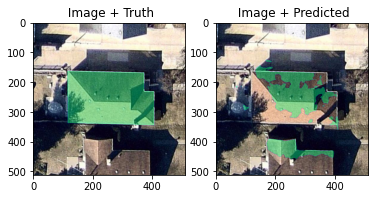

MeanIoU: 0.382  Precision: 0.711  Recall: 0.452


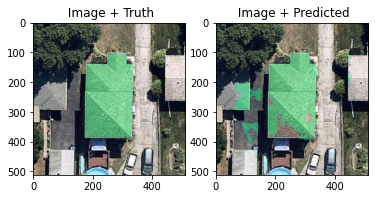

MeanIoU: 0.721  Precision: 0.783  Recall: 0.901


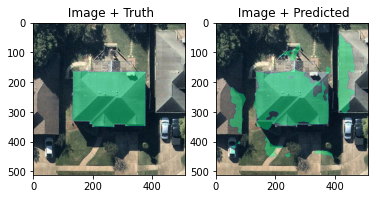

MeanIoU: 0.561  Precision: 0.621  Recall: 0.852


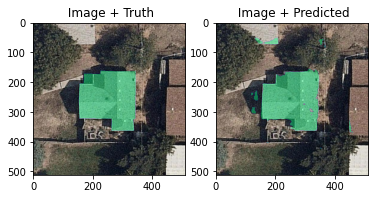

MeanIoU: 0.852  Precision: 0.901  Recall: 0.940


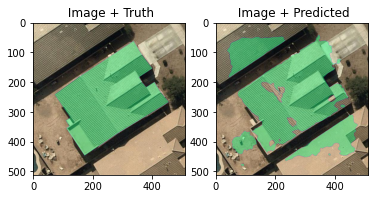

MeanIoU: 0.608  Precision: 0.655  Recall: 0.896


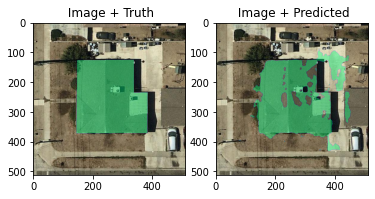

MeanIoU: 0.733  Precision: 0.806  Recall: 0.889


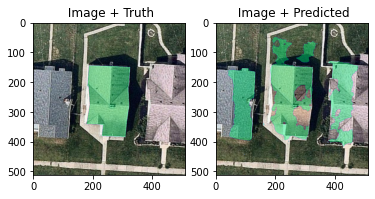

MeanIoU: 0.337  Precision: 0.369  Recall: 0.797


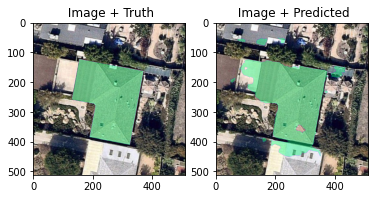

MeanIoU: 0.752  Precision: 0.767  Recall: 0.976


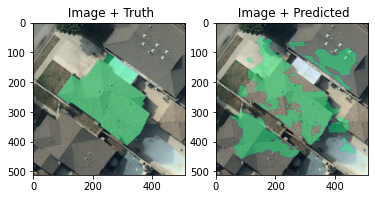

MeanIoU: 0.345  Precision: 0.429  Recall: 0.639
Final MeanIoU:   0.668
Final Precision: 0.787
Final Recall:    0.814


In [20]:
# let's check the output
print('MODEL: model_aug')
avg_MIOU, avg_prec, avg_rec, avg_f1 = [], [], [], []
for ii, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_data(Path(x), True)
    y = read_data(Path(y), True, 255., False)
    with tf.device('/cpu:0'):
        y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    miou = miou_score(y, y_pred)
    prec = precision_score(y.flatten()>0.5, y_pred.flatten()>0.5)
    rec = recall_score(y.flatten()>0.5, y_pred.flatten()>0.5)
    if ii % 20 == 2:
        visualize_image_and_mask(x, y, y_pred>0.5)
        print(f'MeanIoU: {miou:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}')

    avg_MIOU.append(miou)
    avg_prec.append(prec)
    avg_rec.append(rec)

print(f'Final MeanIoU:   {np.mean(avg_MIOU):.3f}')
print(f'Final Precision: {np.mean(avg_prec):.3f}')
print(f'Final Recall:    {np.mean(avg_rec):.3f}')

In [21]:
# Define model save path
if DEFAULT_SAVE_MODEL:
    date_str = datetime.now().strftime('%Y%m%d-%H%M%S')
    save_path = (base_dir.parent / 'src') / ''.join([model_savebase, date_str, '.h5'])
    model.save(save_path)